In [1]:
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('abalone.csv')

In [3]:
First_size = df.shape
First_size

(4177, 9)

In [4]:
df.isna().sum()

Sex                0
Length             0
Diameter          99
Height             0
Whole weight      99
Shucked weight     0
Viscera weight     0
Shell weight      50
Rings              0
dtype: int64

Общее исследование данных: проверить размеры таблицы, число столбцов, количество пропусков в столбцах:
1. Размеры = 4177 строк
2. Столбцов = 9
3. Пропуски в столбиках "Diameter", "Whole weight", "Shell weight", хотя в оригинальном датасете пропусков нет (см ниже) - хм, непонятно...

Работаю с предоставленным датасетом.

In [5]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
abalone = fetch_ucirepo(id=1) 
  
# data (as pandas dataframes) 
X = abalone.data.features 
y = abalone.data.targets 
  
# metadata 
print(abalone.metadata) 
  
# variable information 
print(abalone.variables) 

{'uci_id': 1, 'name': 'Abalone', 'repository_url': 'https://archive.ics.uci.edu/dataset/1/abalone', 'data_url': 'https://archive.ics.uci.edu/static/public/1/data.csv', 'abstract': 'Predict the age of abalone from physical measurements', 'area': 'Biology', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Tabular'], 'num_instances': 4177, 'num_features': 8, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': [], 'target_col': ['Rings'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1994, 'last_updated': 'Mon Aug 28 2023', 'dataset_doi': '10.24432/C55C7W', 'creators': ['Warwick Nash', 'Tracy Sellers', 'Simon Talbot', 'Andrew Cawthorn', 'Wes Ford'], 'intro_paper': None, 'additional_info': {'summary': 'Predicting the age of abalone from physical measurements.  The age of abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope -- 

In [6]:
X.shape, y.shape

((4177, 8), (4177, 1))

In [7]:
X.isna().sum()

Sex               0
Length            0
Diameter          0
Height            0
Whole_weight      0
Shucked_weight    0
Viscera_weight    0
Shell_weight      0
dtype: int64

In [8]:
df.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,NaN,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4078 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4078 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscera weight  4177 non-null   float64
 7   Shell weight    4127 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


In [10]:
df.Sex.unique()

array(['M', 'F', 'I', 'f'], dtype=object)

В столбце Sex есть опечатка, которую я не заметил первый раз. Надо заменить f на F, в результате пола 3, М, Ж и дети.

In [11]:
df['Sex'] = df['Sex'].str.upper()
assert set(df['Sex'].unique()) == {'M', 'F', 'I'}, "Проверка не прошла!"

In [12]:
numeric_columns = ['Length', 'Diameter', 'Height', 'Whole weight', 
                   'Shucked weight', 'Viscera weight', 'Shell weight']
categorical_column = 'Sex'  # Категориальный признак
target_column = 'Rings'

Однофакторный анализ: по каждому столбцу посмотреть его распределение.

Все столбцы числовые, кроме пола ('Sex'), в нем 4 значения - для МО нужно будет OneHotEncoder

Для категориальных данных: Sex - для него построим столбчатую диаграмму (bar plot) и ящик с усами (boxplot)

Для числовых данных: построим гистограмму и ящик с усами (boxplot)

In [13]:
# Распределение
print(df[categorical_column].value_counts())

Sex
F    1454
M    1447
I    1276
Name: count, dtype: int64


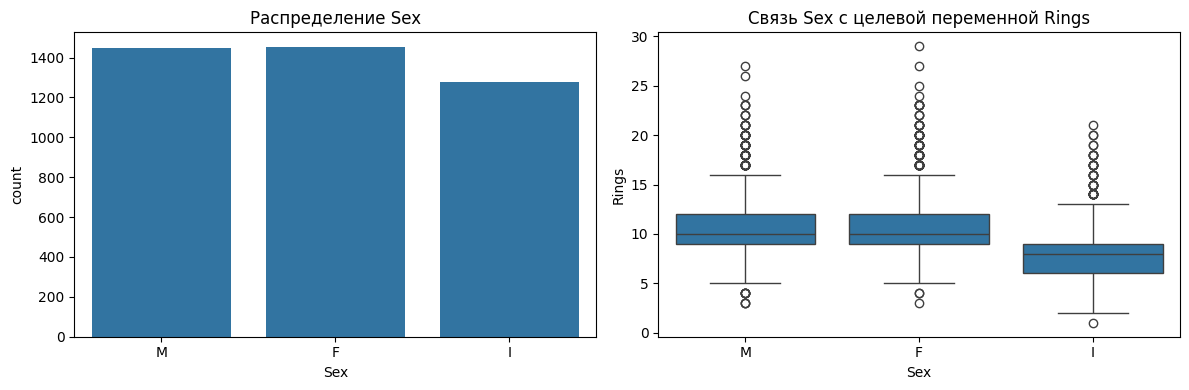

In [14]:
# Создаем сетку из двух графиков в одну строку
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1 строка, 2 столбца

# График распределения Sex
sns.countplot(data=df, x='Sex', ax=axes[0])
axes[0].set_title('Распределение Sex')

# График связи Sex с целевой переменной Rings
sns.boxplot(data=df, x='Sex', y='Rings', ax=axes[1])
axes[1].set_title('Связь Sex с целевой переменной Rings')

# Настройка макета
plt.tight_layout()  # Автоматическая настройка отступов
plt.show()

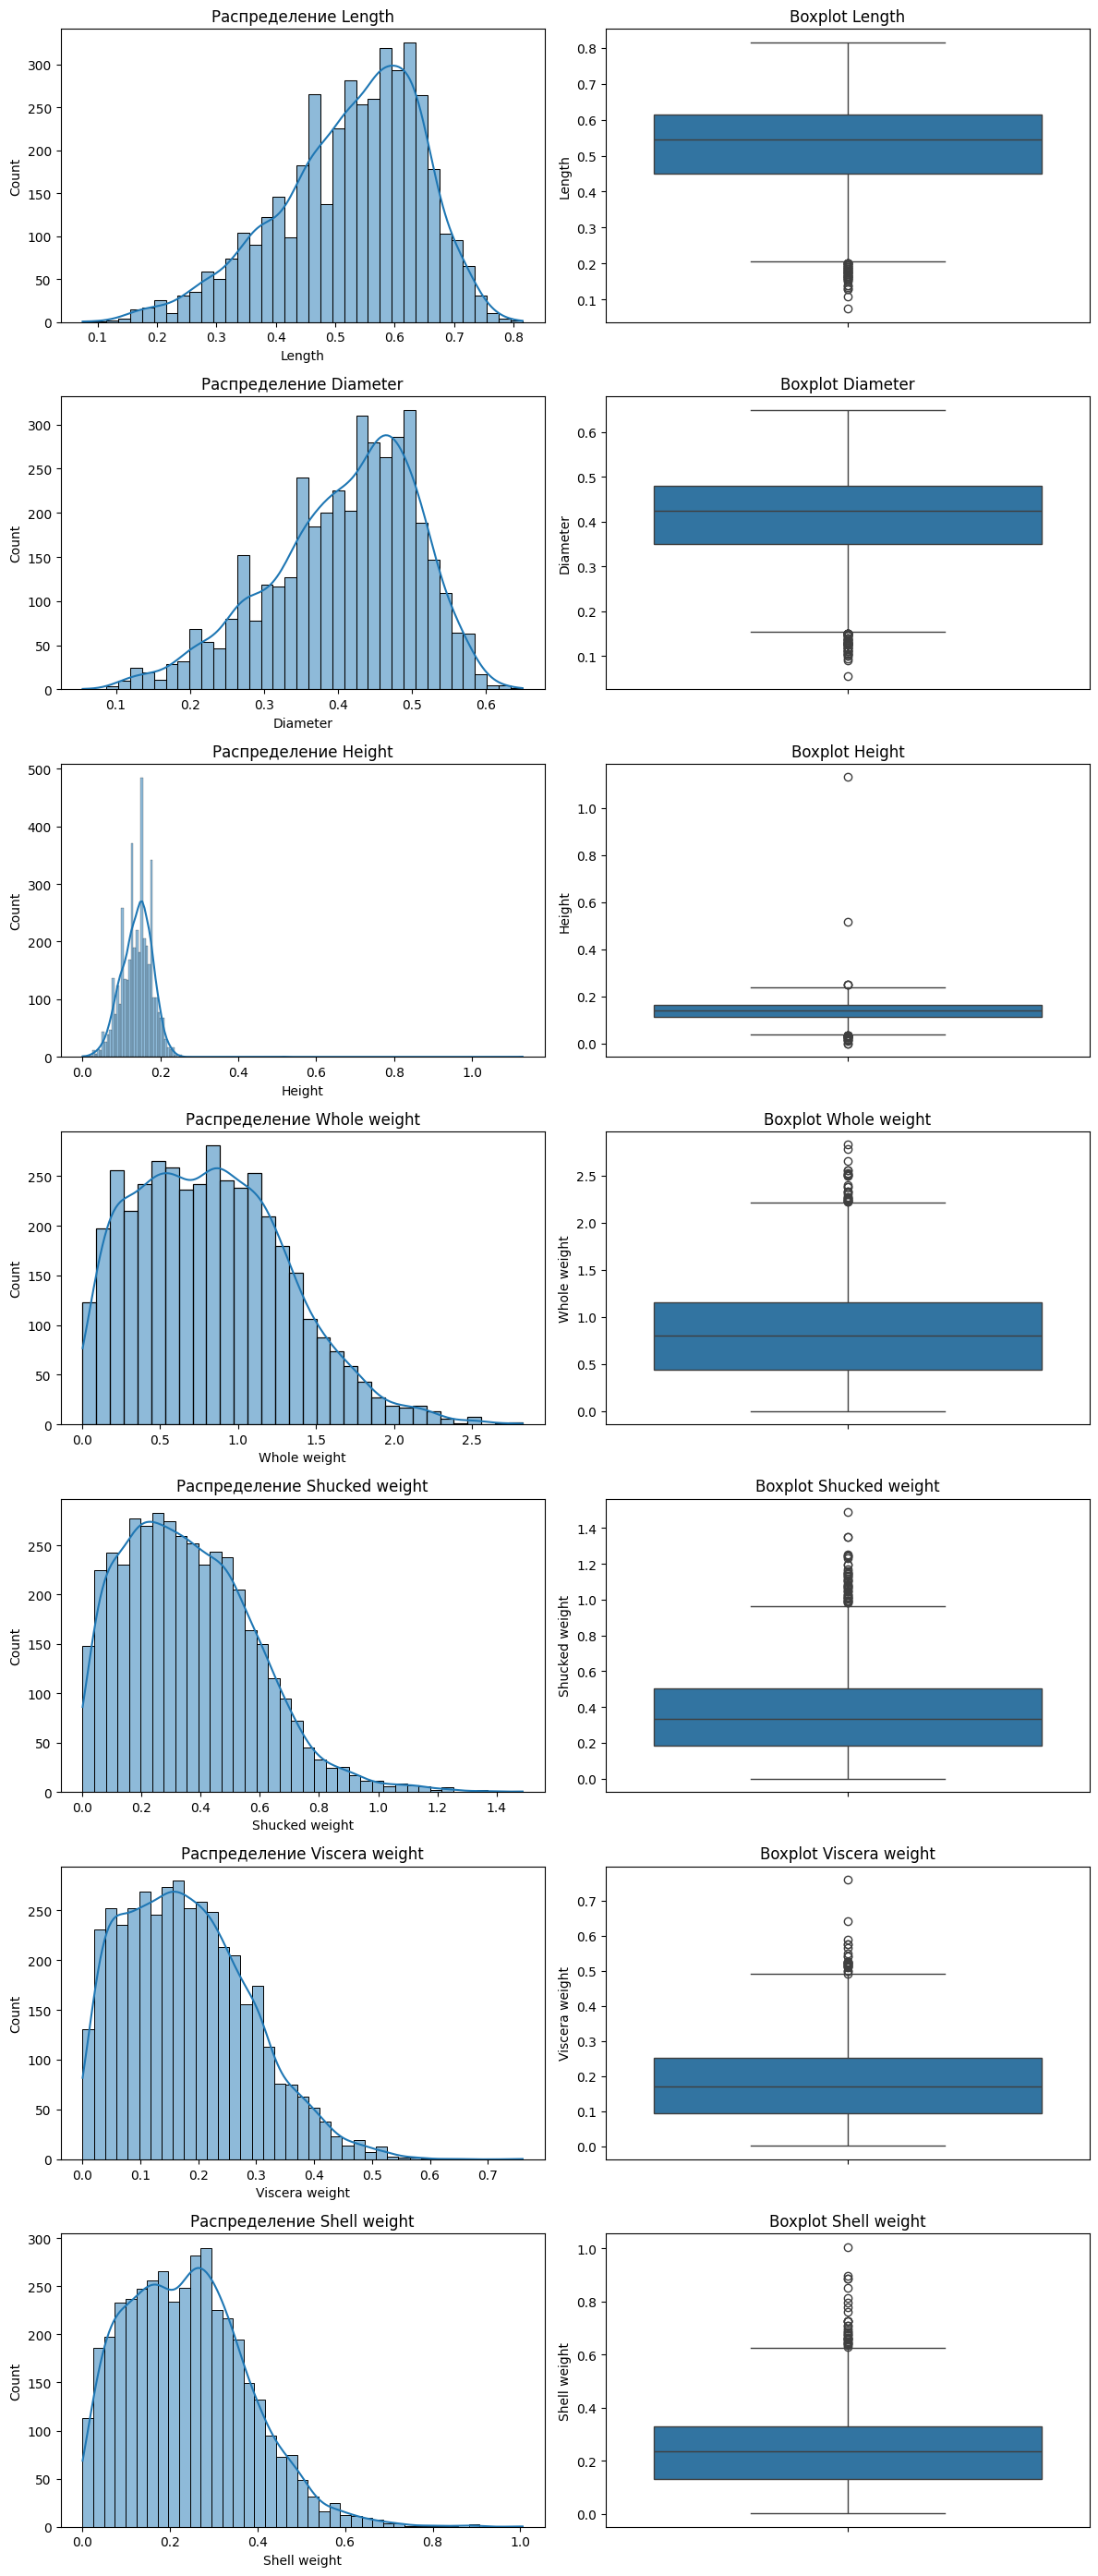

In [15]:
# Количество числовых признаков
num_plots = len(numeric_columns)

# Создаем сетку графиков: по два графика (гистограмма и boxplot) для каждого признака
fig, axes = plt.subplots(num_plots, 2, figsize=(12, 4 * num_plots))  # 2 колонки, num_plots строк

# Перебираем числовые признаки
for i, col in enumerate(numeric_columns):
    # Гистограмма
    sns.histplot(df[col], kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Распределение {col}')
    
    # Ящик с усами
    sns.boxplot(data=df, y=col, ax=axes[i, 1])
    axes[i, 1].set_title(f'Boxplot {col}')

# Настройка макета
plt.tight_layout()  # Автоматическая настройка отступов
plt.show()

Если есть пропуски и ошибочные значения - обработать их.

Явные выбросы по колонке Height, остальное в рамках разумного, хотя все колонки, следующие за Height тоже имеют длинный хвост.

Обработаем колонку Height Методом межквартильного размаха (IQR), хотя, вероятно, можно и другие колонки

In [16]:
numeric_columns_2 = ['Height'] 
#                   'Shucked weight', 'Viscera weight', 'Shell weight']

for col in numeric_columns_2:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Обнаруживаем выбросы
    print(f"Столбец: {col}")
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"Количество выбросов: {len(outliers)}\n")

    # Удаление выбросов
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

# Проверка размера датасета после удаления выбросов
print(f'Потеряно {First_size[0] - df.shape[0]} значений.')

Столбец: Height
Количество выбросов: 29

Потеряно 29 значений.


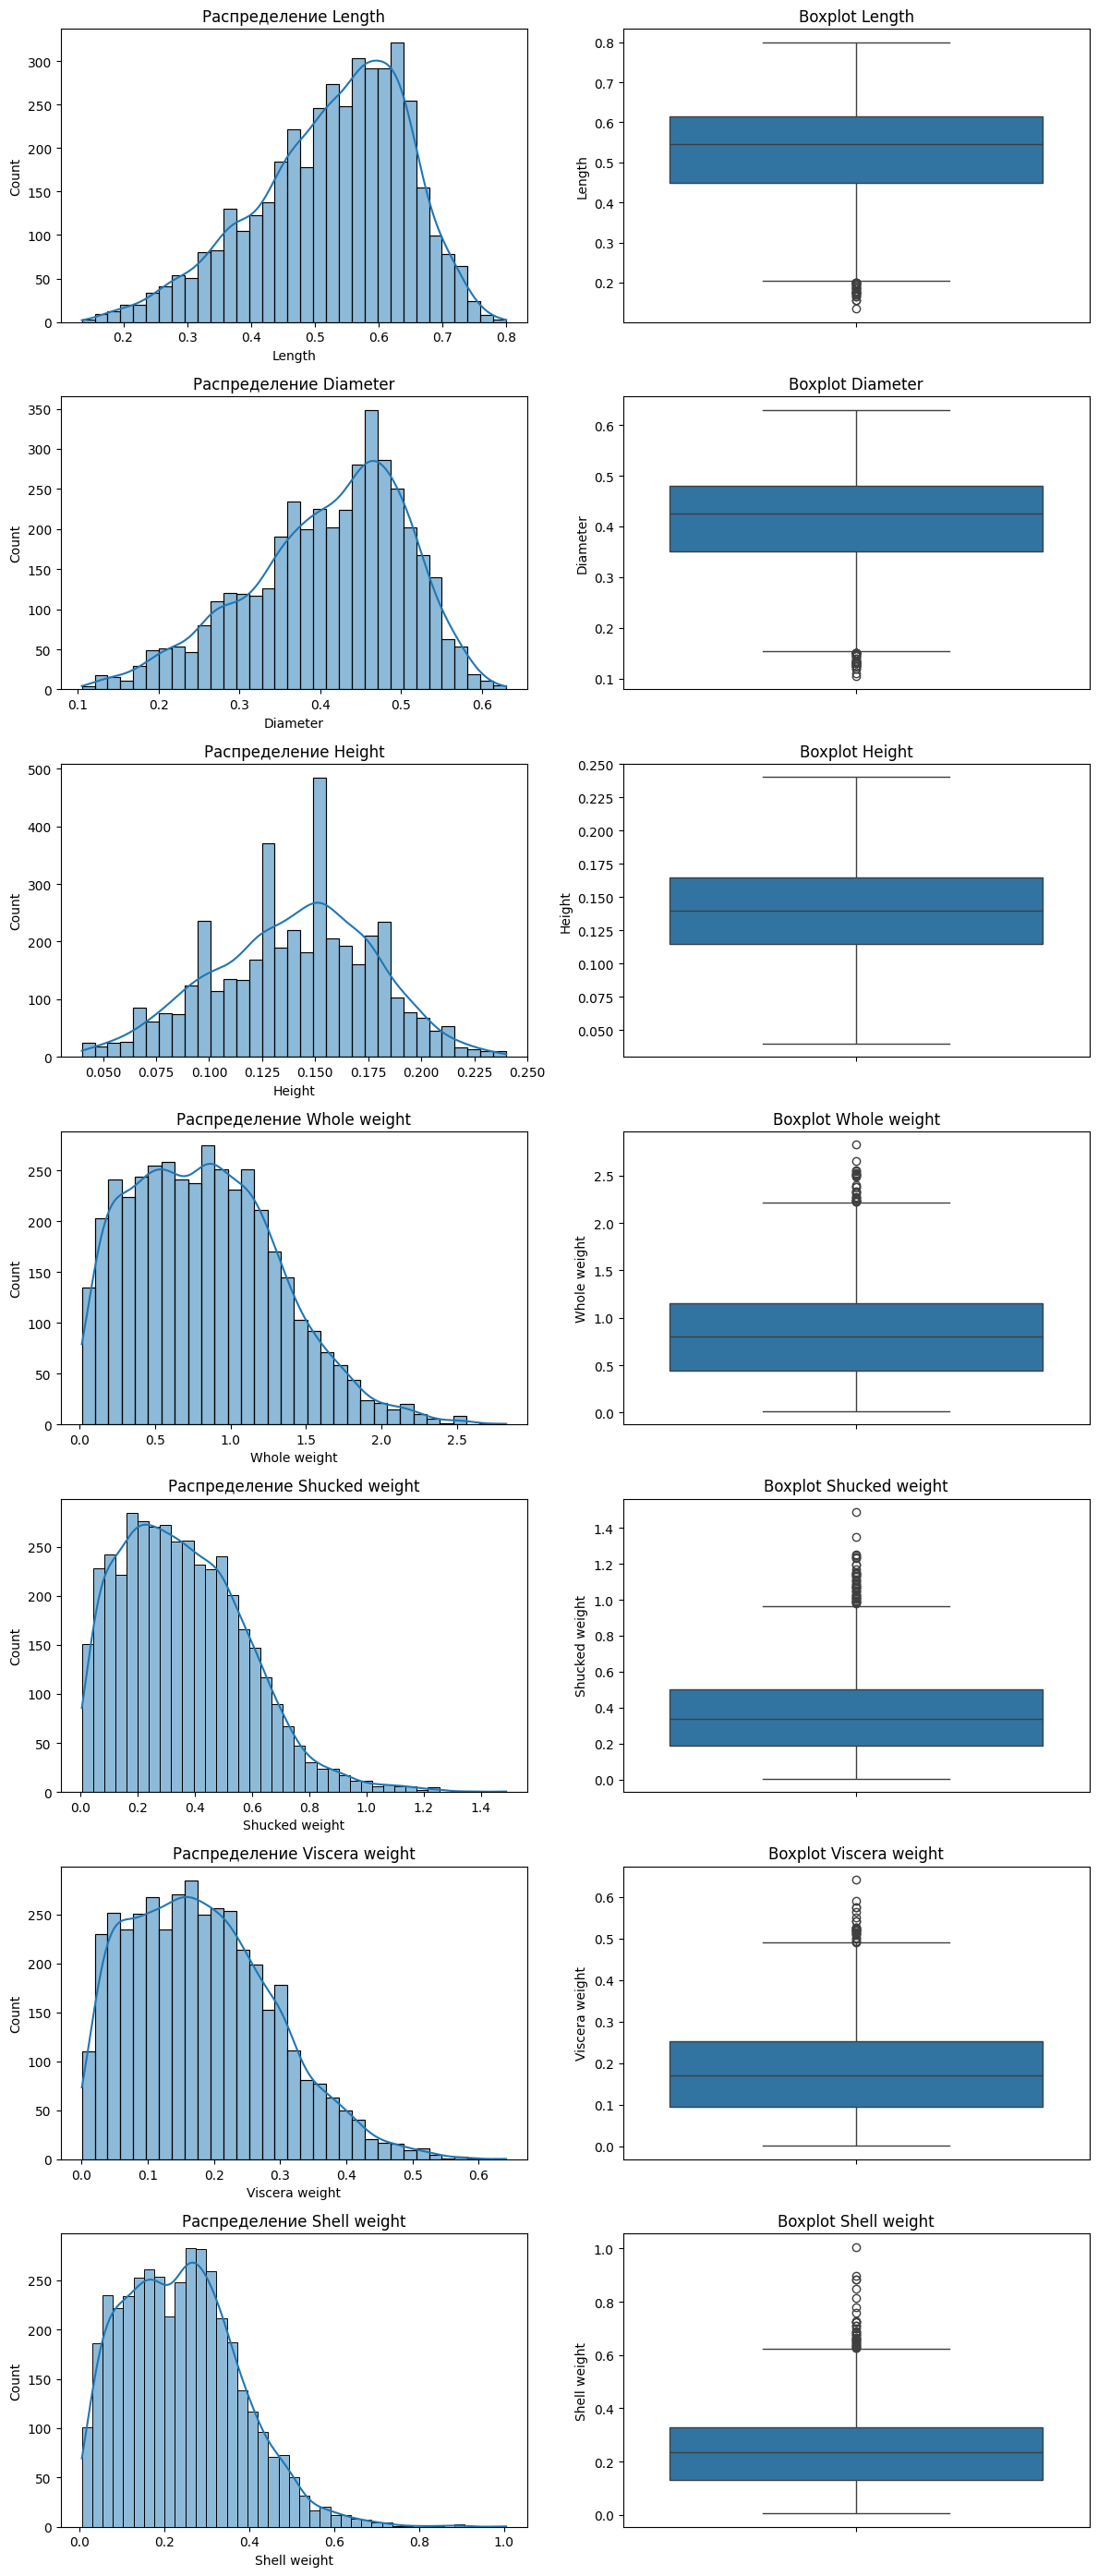

In [17]:
# Для числовых признаков
numeric_columns = ['Length', 'Diameter', 'Height', 'Whole weight', 
                   'Shucked weight', 'Viscera weight', 'Shell weight']

# Количество числовых признаков
num_plots = len(numeric_columns)

# Создаем сетку графиков: по два графика (гистограмма и boxplot) для каждого признака
fig, axes = plt.subplots(num_plots, 2, figsize=(12, 4 * num_plots))  # 2 колонки, num_plots строк

# Перебираем числовые признаки
for i, col in enumerate(numeric_columns):
    # Гистограмма
    sns.histplot(df[col], kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Распределение {col}')
    
    # Ящик с усами
    sns.boxplot(data=df, y=col, ax=axes[i, 1])
    axes[i, 1].set_title(f'Boxplot {col}')

# Настройка макета
plt.tight_layout()  # Автоматическая настройка отступов
plt.show()

Пропуски заполняем медианой - медиана устойчива к выбросам и лучше отражает "типичное" значение. Признаки числовые, с выбросами, поэтому медиана подходит для заполнения пропусков. Среднее чувствительно к выбросам, мода может исказить распределение.

In [18]:
import warnings
warnings.filterwarnings("ignore")

# Заполнение пропусков медианой
for col in numeric_columns:
    median_value = df[col].median()
    df[col].fillna(median_value, inplace=True)

# Проверка
df.isna().sum()

Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Shucked weight    0
Viscera weight    0
Shell weight      0
Rings             0
dtype: int64

### связь с целевой переменной - наблюдается явная положительная линейная зависимость по всем переменным

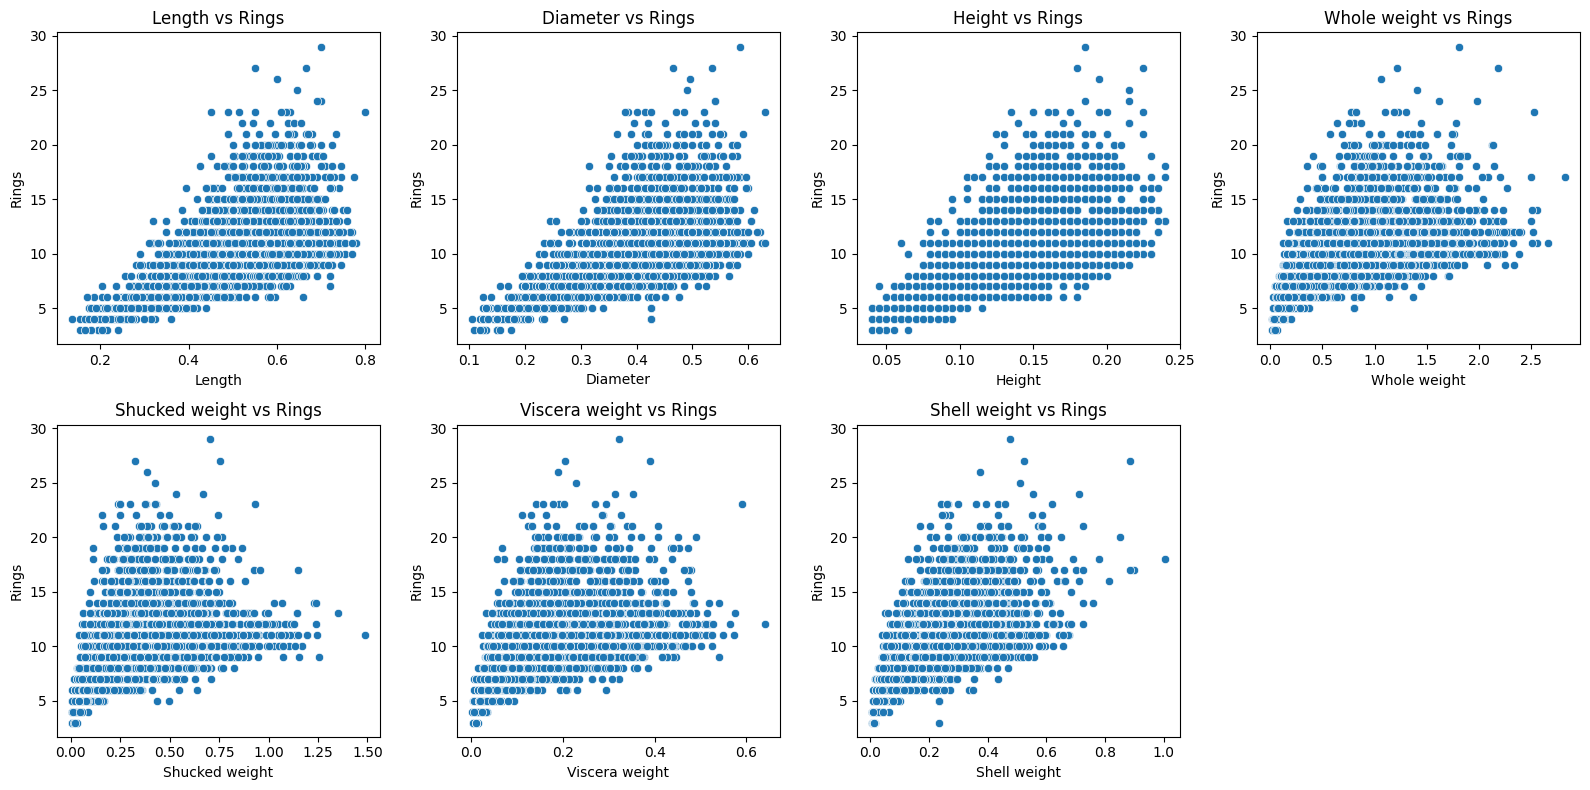

In [19]:
# Количество числовых признаков
num_plots = len(numeric_columns)
rows = (num_plots + 3) // 4  # Вычисляем количество строк (округление вверх)
cols = 4  # Фиксированное количество столбцов

# Создаем сетку графиков
fig, axes = plt.subplots(rows, cols, figsize=(16, 4 * rows))  # Размер зависит от количества строк и столбцов

# Перебираем числовые признаки и рисуем диаграммы рассеяния
for i, col in enumerate(numeric_columns):
    row = i // cols  # Номер строки
    col_idx = i % cols  # Номер столбца
    
    # Рисуем scatter plot
    sns.scatterplot(data=df, x=col, y='Rings', ax=axes[row, col_idx])
    axes[row, col_idx].set_title(f'{col} vs Rings')
    axes[row, col_idx].set_xlabel(col)  # Подпись оси X
    axes[row, col_idx].set_ylabel('Rings')  # Подпись оси Y

# Если количество графиков меньше, чем ячеек в сетке, скрываем лишние оси
for j in range(len(numeric_columns), rows * cols):
    axes.flatten()[j].axis('off')  # Отключаем оси для пустых ячеек

# Настройка макета
plt.tight_layout()  # Автоматическая настройка отступов
plt.show()

Построить матрицу корреляций (или ее аналог для категориальных признаков): использовать корреляции, тест 
χ
2
 , ANOVA

In [20]:
import association_metrics as am

df_cat = df.apply(lambda x: x.astype("category") if x.dtype == "object" else x)

# Преобразуем целевую переменную Rings в категориальную (биннинг)
bins = [0, 5, 10, 15, 20, 30]  # Rings от 0 до 30
labels = ['0-5', '6-10', '11-15', '16-20', '21+']
df_cat['Rings_cat'] = pd.cut(df['Rings'], bins=bins, labels=labels).astype('category')

cramersv = am.CramersV(df_cat)

cramersv_matrix = cramersv.fit()

# Вывод матрицы
print("Матрица Cramér's V:")
print(cramersv_matrix)

Матрица Cramér's V:
                Sex  Rings_cat
Sex        1.000000   0.266358
Rings_cat  0.266358   1.000000


In [21]:
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder

# Преобразуем категориальные признаки в числовой формат
label_encoder = LabelEncoder()
df['Sex_num'] = label_encoder.fit_transform(df[categorical_column])

# Вычисляем χ² для категориальных признаков и целевой переменной
chi_scores, p_values = chi2(df[['Sex_num']], df[target_column])

# Создаем DataFrame с результатами
chi_results = pd.DataFrame({
    'Feature': categorical_column,
    'Chi2 Score': chi_scores,
    'P-Value': p_values
})

print("Результаты теста χ²:")
print(chi_results)

Результаты теста χ²:
  Feature  Chi2 Score   P-Value
0     Sex   13.593351  0.968366


### Вывод по признаку 'Sex'
Согласно матрице Крамера можно сделать вывод о слабой связи признака 'Sex' с целевой переменной, так же по результатам теста χ² мы делаем выводы что связь между признаком 'Sex' и целевой переменной статистически не значима P-Value > 0.05.

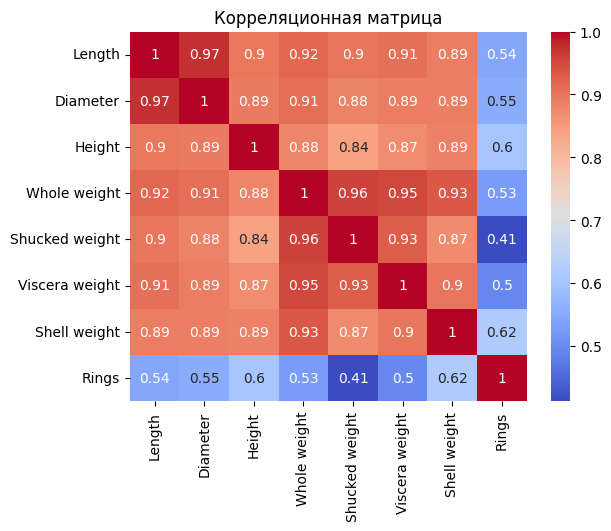

Признаки в порядке убывания значимости для Rings:


Shell weight      0.617
Height            0.601
Diameter          0.553
Length            0.545
Whole weight      0.525
Viscera weight    0.497
Shucked weight    0.412
Name: Rings, dtype: float64

In [22]:
# Корреляционная матрица
correlation_matrix = df[numeric_columns + [target_column]].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Корреляционная матрица')
plt.show()

target_correlations = correlation_matrix[target_column].drop(target_column)
print("Признаки в порядке убывания значимости для Rings:")
round(target_correlations.abs().sort_values(ascending=False), 3)

In [23]:
from sklearn.feature_selection import f_oneway

# Создаем словарь для хранения результатов
anova_results = []

# Для каждого числового признака
for col in numeric_columns:
    # Разделяем данные по категориям Rings_cat
    groups = [df_cat[col][df_cat['Rings_cat'] == category] for category in df_cat['Rings_cat'].cat.categories]
    
    # Вычисляем ANOVA
    f_stat, p_value = f_oneway(*groups)
    f_stat = f_stat[0]  # Извлекаем значение из массива
    p_value = p_value[0]  # Извлекаем значение из массива
    
    # Сохраняем результаты
    anova_results.append({
        'Feature': col,
        'F-Score': f_stat,
        'P-Value': p_value,
        'Is correlated': 'Yes' if p_value < 0.05 else 'No'
    })

# Преобразуем результаты в DataFrame
anova_df = pd.DataFrame(anova_results)

print("Результаты ANOVA:")
print(anova_df)

Результаты ANOVA:
          Feature     F-Score        P-Value Is correlated
0          Length  491.968147   0.000000e+00           Yes
1        Diameter  479.153665   0.000000e+00           Yes
2          Height  516.176770   0.000000e+00           Yes
3    Whole weight  336.078576  7.767189e-251           Yes
4  Shucked weight  218.903311  1.169242e-170           Yes
5  Viscera weight  308.761296  9.069813e-233           Yes
6    Shell weight  479.727640   0.000000e+00           Yes


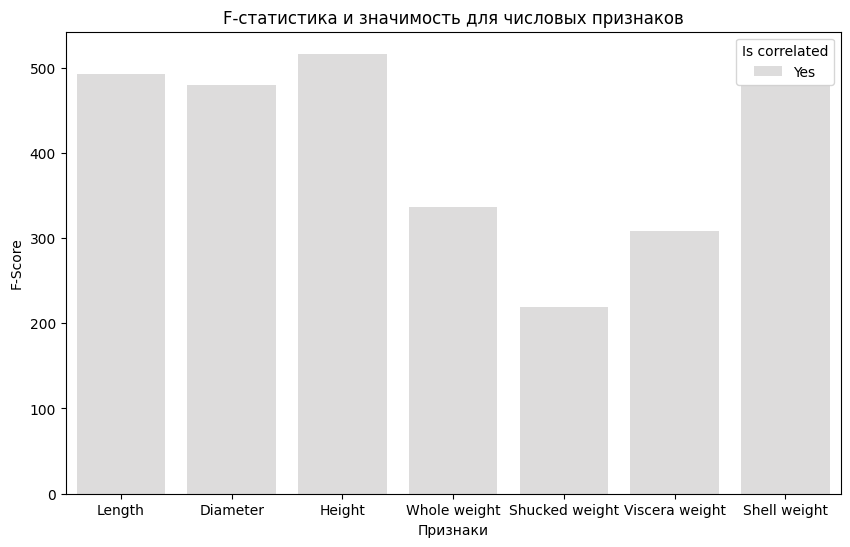

In [24]:
# Визуализация F-статистики и значимости
plt.figure(figsize=(10, 6))
sns.barplot(data=anova_df, x='Feature', y='F-Score', hue='Is correlated', palette='coolwarm')
plt.title('F-статистика и значимость для числовых признаков')
plt.ylabel('F-Score')
plt.xlabel('Признаки')
plt.legend(title='Is correlated')
plt.show()

### Вывод по числовым признакам
Согласно построенной матрице корреляции и полученным результатам ANOVA теста мы наблюдаем корреляцию числовых признаков с целевой переменной.
P-Value < 0.05 для всех признаков, связь между признаком и целевой переменной  статистически значима.

Провести анализ целевой переменной - на какое распределение больше всего похожа ее гистограмма? Какие проблемы в связи с этим могут возникнуть при обучении моделей?

### Выводы по целевой переменной
Мы видим логнормальное распределение. У распределения длинный хвост, который может быть трудно прогнозируем моделями (так как там мало значений).

Но если прологарифмировать целевую переменную, то получаем вполне нормальное распределение.

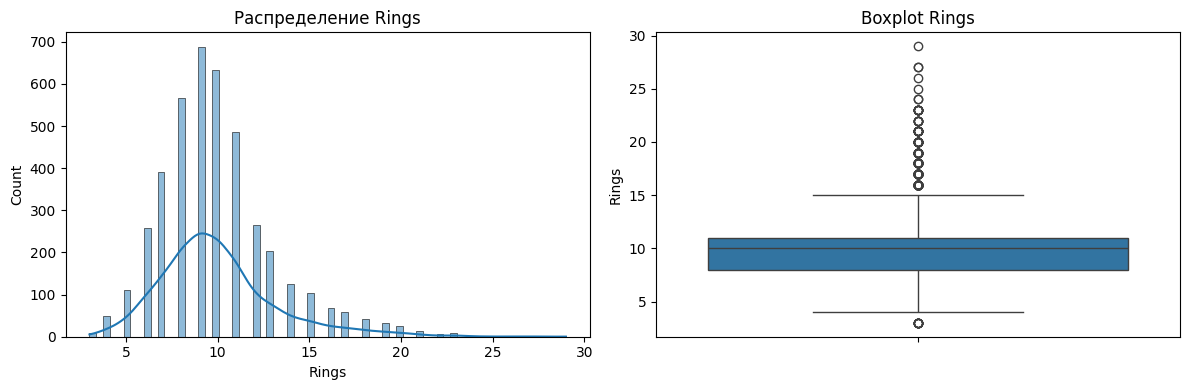

In [25]:
# Создаем сетку из двух графиков в одну строку
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1 строка, 2 столбца

# Гистограмма
sns.histplot(df[target_column], kde=True, ax=axes[0])
axes[0].set_title(f'Распределение Rings')

# График целевой переменной Rings
sns.boxplot(data=df, y=target_column, ax=axes[1])
axes[1].set_title('Boxplot Rings')

# Настройка макета
plt.tight_layout()  # Автоматическая настройка отступов
plt.show()

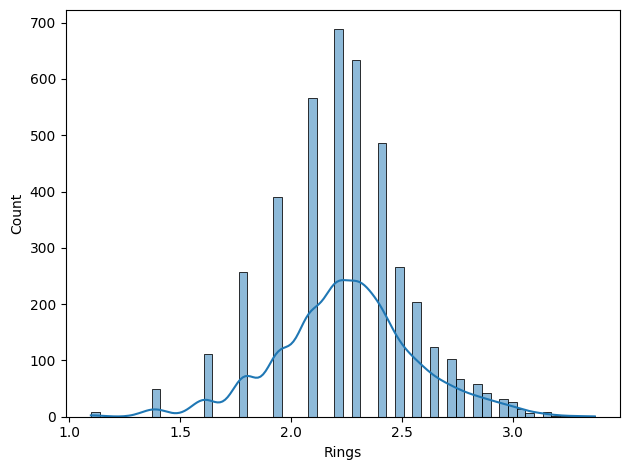

In [26]:
sns.histplot(data = np.log(df[target_column]), kde = True)
plt.tight_layout()  # Автоматическая настройка отступов
plt.show()

Увеличить размер данных простым дублированием до 1_000_000 строк в датасете. Провести сравнение скорости работы Pandas и Polars на увеличенном датасете по параметрам:
- загрузка данных (1 балл)
- фильтрация данных (1 балл)
- агрегация данных (1 балл)

In [27]:
import time

# Увеличение размера данных до 1_000_000 строк
num_copies = -(-1_000_000 // len(df))  # Количество копий для достижения 1_000_000 строк
df_large = pd.concat([df] * num_copies, ignore_index=True)[:1_000_000]

# Сохранение увеличенного датасета в файл для Polars
df_large.to_csv('abalone_large.csv', index=False)

In [28]:
num_copies * len(df)

1003816

In [29]:
# Загрузка данных в Pandas
start_time = time.time()
df_pandas = pd.read_csv('abalone_large.csv')
pandas_load_time = time.time() - start_time

# Загрузка данных в Polars
start_time = time.time()
df_polars = pl.read_csv('abalone_large.csv')
polars_load_time = time.time() - start_time

print(f"Время загрузки данных (Pandas): {pandas_load_time:.4f} сек")
print(f"Время загрузки данных (Polars): {polars_load_time:.4f} сек")

Время загрузки данных (Pandas): 0.4937 сек
Время загрузки данных (Polars): 0.1477 сек


In [30]:
df_pandas.shape, df_polars.shape

((1000000, 10), (1000000, 10))

In [31]:
# Фильтрация данных в Pandas
start_time = time.time()
filtered_pandas = df_pandas[df_pandas['Rings'] > 10]
pandas_filter_time = time.time() - start_time

# Фильтрация данных в Polars
start_time = time.time()
filtered_polars = df_polars.filter(pl.col('Rings') > 10)
polars_filter_time = time.time() - start_time

print(f"Время фильтрации данных (Pandas): {pandas_filter_time:.4f} сек")
print(f"Время фильтрации данных (Polars): {polars_filter_time:.4f} сек")

Время фильтрации данных (Pandas): 0.0199 сек
Время фильтрации данных (Polars): 0.0405 сек


In [32]:
# Агрегация данных в Pandas
start_time = time.time()
aggregated_pandas = df_pandas.groupby('Sex')['Rings'].mean()
pandas_agg_time = time.time() - start_time

# Агрегация данных в Polars
start_time = time.time()
aggregated_polars = df_polars.group_by('Sex').agg(pl.col('Rings').mean())
polars_agg_time = time.time() - start_time

print(f"Время агрегации данных (Pandas): {pandas_agg_time:.4f} сек")
print(f"Время агрегации данных (Polars): {polars_agg_time:.4f} сек")

Время агрегации данных (Pandas): 0.0438 сек
Время агрегации данных (Polars): 0.0239 сек


### Выводы
- Polars быстрее загружает данные
- Polars быстрее выполняет фильтрацию
- Polars быстрее выполняет агрегацию

Надо отметить, что операции фильтрации и агрегации не очень сильно различаются по времени, т.е. разница на третьем знаке.